In [1]:
%load_ext autoreload 
%autoreload 2   

In [2]:
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from tqdm import tqdm
from torchvision import models
import torchvision
import os

from data import PermutedMNIST
from utils import EWC, ewc_train, normal_train, test

In [3]:
epochs = 50
lr = 1e-3
batch_size = 128
sample_size = 200
hidden_size = 200
num_task = 3

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_size=400):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 10)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

In [5]:
def get_permute_mnist():
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(num_task):
        train_loader[i] = torch.utils.data.DataLoader(
            PermutedMNIST(train=True, permute_idx=idx),
            batch_size=batch_size,
            num_workers=4,
        )
        test_loader[i] = torch.utils.data.DataLoader(
            PermutedMNIST(train=False, permute_idx=idx), batch_size=batch_size
        )
        random.shuffle(idx)
    return train_loader, test_loader


train_loader, test_loader = get_permute_mnist()

In [10]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v, label=f"task {t}")


def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(
            list(range(t * epochs, num_task * epochs)),
            [i.detach().cpu().numpy() for i in v],
        )
    plt.ylim(0, 1)

### Standard Model 

In [7]:
use_cuda = True

project_name = "naive_MNIST"
# cl_strategy, initial_exp = maybe_load_checkpoint(cl_strategy, "./0_checkpoint.pth")
if not os.path.exists(f"./results/{project_name}/"):
    os.makedirs(f"./results/{project_name}/")

In [8]:
model = MLP(hidden_size)

if torch.cuda.is_available() and use_cuda:
    model.cuda()
optimizer = optim.SGD(params=model.parameters(), lr=lr)

weight = []
loss, acc = {}, {}
for task in range(num_task):
    loss[task] = []
    acc[task] = []
    for _ in tqdm(range(epochs)):
        loss[task].append(normal_train(model, optimizer, train_loader[task]))
        for sub_task in range(task + 1):
            acc[sub_task].append(test(model, test_loader[sub_task]))
    torch.save(model.state_dict(), f"./results/{project_name}/{task}_checkpoint.pth")

    if task == 0 and weight:
        weight.append(model.state_dict())

100%|██████████| 50/50 [01:13<00:00,  1.48s/it]


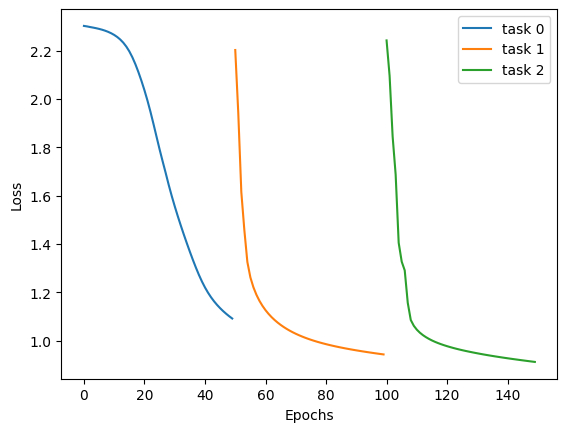

In [15]:
# loss_plot(loss)

for t, v in loss.items():
    plt.plot(list(range(t * epochs, (t + 1) * epochs)), v, label=f"task {t}")


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

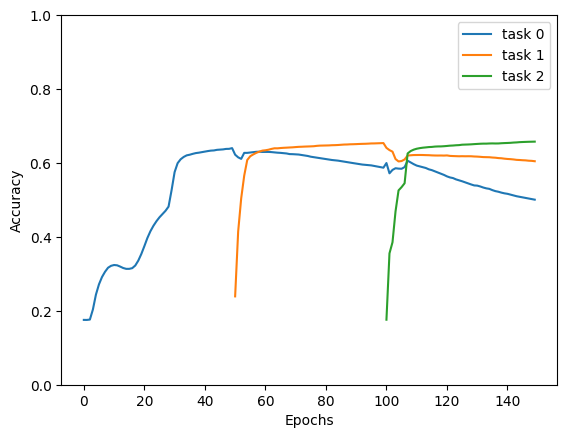

In [19]:
for t, v in acc.items():
    plt.plot(
        list(range(t * epochs, num_task * epochs)),
        [i.detach().cpu().numpy() for i in v],
        label=f"task {t}",
    )
plt.ylim(0, 1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## EWC

In [20]:
model = MLP(hidden_size)

importance = 1000
use_cuda = True
weight = None

In [21]:
project_name = "EWC_MNIST"
if not os.path.exists(f"./results/{project_name}/"):
    os.makedirs(f"./results/{project_name}/")

In [22]:
if torch.cuda.is_available() and use_cuda:
    model.cuda()
optimizer = optim.SGD(params=model.parameters(), lr=lr)

loss, acc, ewc = {}, {}, {}
for task in range(num_task):
    loss[task] = []
    acc[task] = []

    if task == 0:
        if weight:
            model.load_state_dict(weight)
        else:
            for _ in tqdm(range(epochs)):
                loss[task].append(normal_train(model, optimizer, train_loader[task]))
                acc[task].append(test(model, test_loader[task]))
    else:
        old_tasks = []
        for sub_task in range(task):
            old_tasks = old_tasks + train_loader[sub_task].dataset.get_sample(
                sample_size
            )
        old_tasks = random.sample(old_tasks, k=sample_size)
        for _ in tqdm(range(epochs)):
            loss[task].append(
                ewc_train(
                    model,
                    optimizer,
                    train_loader[task],
                    EWC(model, old_tasks),
                    importance,
                )
            )

            torch.save(
                model.state_dict(), f"./results/{project_name}/{task}_checkpoint.pth"
            )

            for sub_task in range(task + 1):
                acc[sub_task].append(test(model, test_loader[sub_task]))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [02:05<00:00,  2.52s/it]


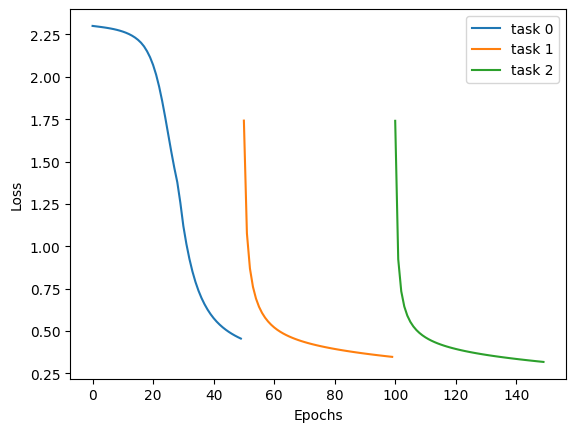

In [23]:
# loss_plot(loss)

for t, v in loss.items():
    plt.plot(list(range(t * epochs, (t + 1) * epochs)), v, label=f"task {t}")


plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

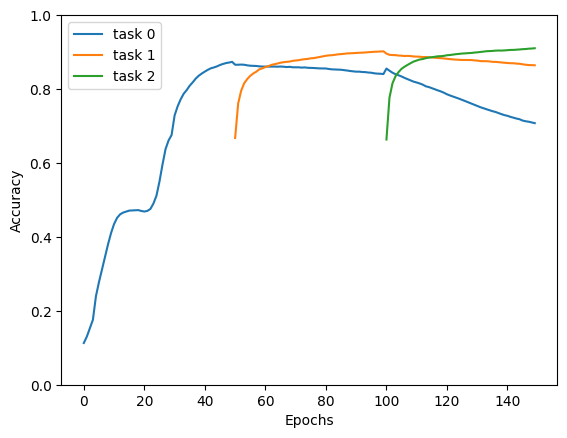

In [24]:
for t, v in acc.items():
    plt.plot(
        list(range(t * epochs, num_task * epochs)),
        [i.detach().cpu().numpy() for i in v],
        label=f"task {t}",
    )
plt.ylim(0, 1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
# from torchvision import datasets, transforms

# train_dataset = datasets.CIFAR100("../data", train=True, download=True)

In [ ]:
# import sys

# sys.path.append("../../")
# from mftma.manifold_analysis_correlation import manifold_analysis_corr
# from mftma.utils.make_manifold_data import make_manifold_data
# from mftma.utils.activation_extractor import extractor
# from mftma.utils.analyze_pytorch import analyze

In [ ]:
# import utils

# model = MLP(hidden_size).to(torch.device("cuda:0"))

# data = []

# for input, target in train_loader[0]:
#     input, target = utils.variable(input), utils.variable(target)
#     data.append(input)

In [ ]:
# activations = extractor(model, data, layer_types=["Linear"])

In [ ]:
# import numpy as np

In [ ]:
# for layer, data in activations.items():
#     X = [d.reshape(d.shape[0], -1).T for d in data]
#     # Get the number of features in the flattened data
#     N = X[0].shape[0]
#     # If N is greater than 5000, do the random projection to 5000 features
#     if N > 5000:
#         print("Projecting {}".format(layer))
#         M = np.random.randn(5000, N)
#         M /= np.sqrt(np.sum(M * M, axis=1, keepdims=True))
#         X = [np.matmul(M, d) for d in X]
#     activations[layer] = X

In [ ]:
# capacities = []
# radii = []
# dimensions = []
# correlations = []
# names = []

# cnt = 0

# for k, X in activations.items():
#     cnt += 1
#     # Analyze each layer's activations
#     a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)

#     # Compute the mean values
#     a = 1 / np.mean(1 / a)
#     r = np.mean(r)
#     d = np.mean(d)
#     print(
#         "{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(
#             k, a, r, d, r0
#         )
#     )

#     # Store for later
#     capacities.append(a)
#     radii.append(r)
#     dimensions.append(d)
#     correlations.append(r0)
#     names.append(k)

In [ ]:
# fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# axes[0].plot(capacities, linewidth=5)
# axes[1].plot(radii, linewidth=5)
# axes[2].plot(dimensions, linewidth=5)
# axes[3].plot(correlations, linewidth=5)

# axes[0].set_ylabel(r"$\alpha_M$", fontsize=18)
# axes[1].set_ylabel(r"$R_M$", fontsize=18)
# axes[2].set_ylabel(r"$D_M$", fontsize=18)
# axes[3].set_ylabel(r"$\rho_{center}$", fontsize=18)

# names = list(activations.keys())
# names = [n.split("_")[1] + " " + n.split("_")[2] for n in names]
# for ax in axes:
#     ax.set_xticks([i for i, _ in enumerate(names)])
#     ax.set_xticklabels(names, rotation=90, fontsize=16)
#     ax.tick_params(axis="both", which="major", labelsize=14)

# plt.tight_layout()
# plt.show()